In [1]:
# SAVE 데이터 로드
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

### 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan
SAVE = SAVE.loc[pd.to_datetime('2017-01-01 00:00'):,:]

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

### 라벨 로드
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

# 라벨 순서를 데이터 순서와 맞춤
valid_col = []
for col in SAVE.columns:
    if col in SAVE_label.columns:
        valid_col.append(col)

SAVE_label = SAVE_label[valid_col].T
SAVE = SAVE[valid_col]
print('Done load SAVE')
SAVE[SAVE == 0] = np.nan

# CER 데이터 로드
# %% load dataset
# start_date = pd.to_datetime('2010-09-01 00:00:00')
# end_date = pd.to_datetime('2009-12-01 23:00:00')

power_df = pd.read_csv('data/CER/power_comb_SME_included.csv')

# 0 to NaN
power_df[power_df==0] = np.nan
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# load label
CER_label = pd.read_csv('data/CER/survey_processed_0427.csv')
CER_label['ID'] = CER_label['ID'].astype(str)
CER_label.set_index('ID', inplace=True)

CER = power_df.loc[:,CER_label.index]
del power_df
print('Done load CER')

## 기간을 6개월 한정
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:45:00')

SAVE = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-06-30 23:30:00')

CER = CER.loc[start_date:end_date,:]

# Downsampling SAVE
n = SAVE.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = SAVE.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.sum(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(SAVE.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
SAVE = list_
del list_

# load ETRI
ETRI = pd.read_csv('data/ETRI/label_0427.csv', index_col=0)
ETRI.index = pd.to_datetime(ETRI.index)
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:00:00')
ETRI = ETRI.loc[start_date:end_date,:]
ETRI_label = pd.read_csv('data/ETRI/survey_0427.csv', index_col = 0)
ETRI[ETRI == 0] = np.nan

nan_ratio = pd.isnull(SAVE).sum(axis=0) / SAVE.shape[0]
invalid_idx = (nan_ratio == 1)
SAVE = SAVE.loc[:,~invalid_idx]
SAVE_label = SAVE_label.loc[~invalid_idx,:]

# invalid house processing
nan_ratio = pd.isnull(CER).sum(axis=0) / CER.shape[0]
invalid_idx = (nan_ratio == 1)
CER = CER.loc[:,~invalid_idx]
CER_label = CER_label.loc[~invalid_idx,:]

print(CER.shape)
print(CER_label.shape)

nan_ratio = pd.isnull(ETRI).sum(axis=0) / ETRI.shape[0]
invalid_idx = (nan_ratio == 1)
ETRI = ETRI.loc[:,~invalid_idx]
ETRI_label = ETRI_label.T.loc[~invalid_idx,:]

print(SAVE.shape)
print(CER.shape)


Done load SAVE
Done load CER
(8688, 3248)
(3248, 15)
(8688, 3192)
(8688, 3248)


In [2]:
def transform(df, sampling_interv = 24 * 2 * 7):
    '''
    [input]
    df: dataframe (timeseries, home)
    
    [output]
    data_2d: 2d array
    home_arr: home index array
    '''

    # dataframe => 3d numpy array
    n_d, n_h = df.shape
    n_w = n_d // sampling_interv
    n_d = n_w * sampling_interv
    df_rs = df.iloc[:n_d,:].values.T.reshape(n_h, -1, sampling_interv)

    # 3d numpy array => 2d numpy array
    n, m, l = df_rs.shape
    data_2d = df_rs.reshape(n*m, l)
    home_arr = np.repeat(np.arange(0, n), m)
    invalid_idx = np.any(pd.isnull(data_2d), axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    # constant load filtering
    invalid_idx = np.nanmin(data_2d, axis=1) == np.nanmax(data_2d, axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    return data_2d, home_arr

# 2d daily 형태로 변환 (house * day , hour)
CER_rs, home_arr_c = transform(CER, 24 * 2)
SAVE_rs, home_arr_s = transform(SAVE, 24 * 2)

data_dict = dict()

for name in ['CER','SAVE']:
    if name == 'CER':
        data_raw = CER_rs
        label_raw = CER_label['Q13'].values
        home_arr = home_arr_c
    elif name == 'ETRI':
        data_raw = ETRI_rs
        label_raw = ETRI_label['popl_num'].values
        home_arr = home_arr_e
    elif name == 'SAVE':
        data_raw = SAVE_rs
        label_raw = SAVE_label['Q2'].values
        home_arr = home_arr_s

    invalid_idx = pd.isnull(label_raw)
    # label_raw = label_raw[~invalid_idx]
    invalid_home_num = np.where(invalid_idx)[0]
    valid_home_idx = np.zeros(home_arr.shape, dtype = bool)
    for j in range(home_arr.shape[0]):
        if home_arr[j] in invalid_home_num:
            valid_home_idx[j] = False
        else:
            valid_home_idx[j] = True
    data_raw = data_raw[valid_home_idx,:]
    home_arr = home_arr[valid_home_idx]
    unique_home_arr = np.unique(home_arr)
    label = np.array([label_raw[u] for u in unique_home_arr])

    data_dict[name] = [data_raw, label, home_arr]

rep_load_dict = dict()
label_dict = dict()
for name in ['CER','SAVE']:
    data_raw, label, home_arr = data_dict[name]
    unique_home_arr = np.unique(home_arr)
    rep_load_list = []
    for i, home_idx in enumerate(unique_home_arr):
        data = data_raw[home_arr == home_idx,:]
        rep_load_list.append(data.mean(axis=0))
    rep_load_dict[name] = np.array(rep_load_list)
    label_dict[name] = label

### Scatter plot

/home/ubuntu/Documents/mskim/household-characteristic-inference/module/util_0607.py:412: RuntimeWarning: divide by zero encountered in log2
  H_con += (1 / 2 * np.log2(2 * np.pi * np.e * sig_ ** 2)) * prob[ii]


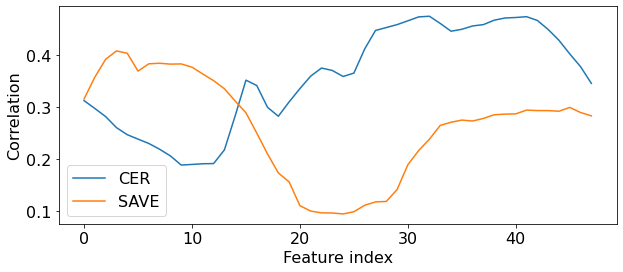

In [133]:
from module.util_0607 import *

plt.figure(figsize = (10, 4))
corr_dict = dict()
for name in ['CER','SAVE']:
    # data_ex = feature_extraction_v2(rep_load_dict[name]).T
    # data_concat = np.concatenate([rep_load_dict[name], data_ex], axis=1)
    # rep_load_dict[name + '_concat'] = data_concat
    _, corr_, _ = evaluate_features(rep_load_dict[name], label_dict[name])
    corr_dict[name] = corr_
    plt.plot(corr_, label = name)
    # print(corr_)

plt.legend()
plt.xlabel('Feature index')
plt.ylabel('Correlation')
plt.show()


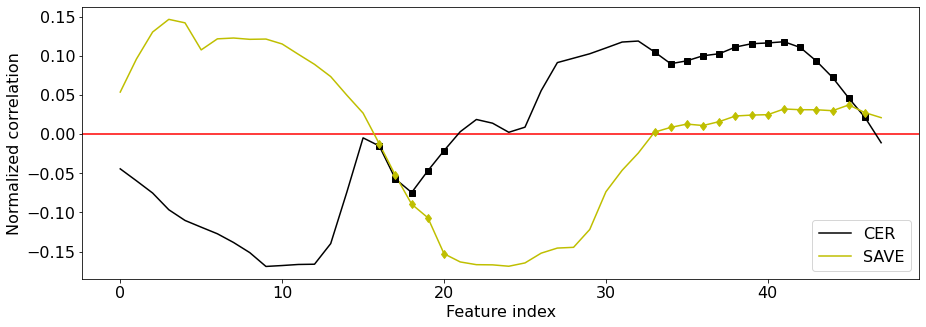

In [134]:
def normalize(data):
    mean_ = data.mean()
    std_ = data.std()
    data = (data - mean_)
    return data

plt.figure(figsize = (15, 5))
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(normalize(corr_dict['CER']), label = 'CER', color = 'k')
plt.plot(normalize(corr_dict['SAVE']), label = 'SAVE', color = 'y')
same = normalize(corr_dict['CER']) * normalize(corr_dict['SAVE']) >= 0
plt.plot(np.where(same)[0], normalize(corr_dict['CER'])[same], 's', color = 'k')
plt.plot(np.where(same)[0], normalize(corr_dict['SAVE'])[same], 'd', color = 'y')
plt.xlabel('Feature index')
plt.ylabel('Normalized correlation')
plt.legend()
plt.show()

In [99]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# from module.util_main import TCA
Xs, Ys, Xt, Yt = rep_load_dict['CER'], label_dict['CER'], rep_load_dict['SAVE'], label_dict['SAVE']
Ys = Ys.copy()
Yt = Yt.copy()

Ys[Ys<=2] = 0
Ys[Ys>2] = 1

Yt[Yt<=2] = 0
Yt[Yt>2] = 1

# Split target data
Xt1, Xt2, Yt1, Yt2  = train_test_split(Xt, Yt, train_size=0.75, random_state=42, shuffle = True)

# transfer learning
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xs, Ys.ravel())
Yt_pred = clf.predict(Xt2)
print((Yt2 == Yt_pred).mean())

# feature selected transfer learning
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xs[:,same], Ys.ravel())
Yt_pred = clf.predict(Xt2[:,same])
print((Yt2 == Yt_pred).mean())

# self learning
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xt1, Yt1)
Yt_pred= clf.predict(Xt2)
print((Yt2 == Yt_pred).mean())

0.5083655083655083


IndexError: boolean index did not match indexed array along dimension 1; dimension is 336 but corresponding boolean dimension is 90

## Case 1: transfer learning with various feature set

In [13]:
model_dict = dict()

Validation acc is 0.5 and Test acc is 0.6662366978394066
Validation auc is 0.6 and Test auc is 0.7274294463706558
Train loss is 0.652, Val loss is 0.688


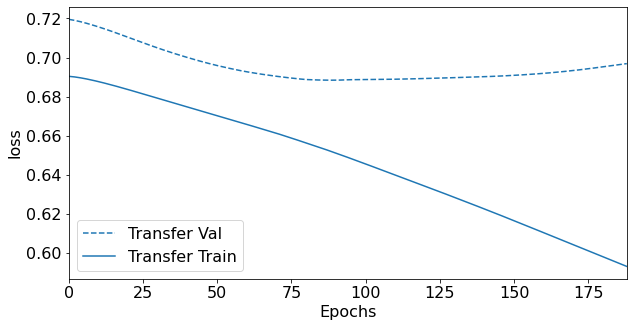

Train acc is 0.548, Val acc is 0.625


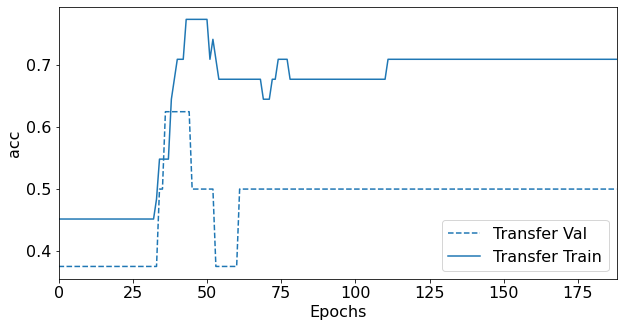

In [154]:
from module.util import *

same = np.zeros((48), dtype = bool)
same[:20] = True
same[40:] = True

model_name = 'CER_set7'

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

params = {
    'lr': 0.001,
    'epoch': 1000,
    'batch_size': 128,
    'lambda': 0.01,
    'epsilon': 0.01,
}
label_ref = label_dict['CER'].copy()
label_ref[label_ref<=2] = 0
label_ref[label_ref>2] = 1

data = rep_load_dict['CER']
params = make_param_int(params, ['batch_size'])
label = to_categorical(label_ref.copy(), dtype=int)
label = label.astype(float)

X_train, X_test, y_train, y_test = train_test_split(data[:,same], label, test_size = 0.2, random_state = 3, stratify = label)

""" 
CNN based feature selection
"""
# reshape
# X_train = X_train.reshape(-1,1, same.sum(), 1)
# X_test = X_test.reshape(-1,1, same.sum(), 1)

# model = CNN_softmax(params, True, label)
model = DNN_model(params, True, label, n_feature = same.sum())
# optimizer = Adam(params['lr'] * 0.1, epsilon=params['epsilon'])
# model.compile(optimizer=optimizer, loss='binary_crossentropy')

es = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=0,
    mode='min',
    restore_best_weights=True
)
lr =  tf.keras.callbacks.LearningRateScheduler(scheduler)

history_tr_1 = model.fit(X_train, y_train, epochs=10000, verbose=0, validation_data=(X_test, y_test),batch_size=params['batch_size'], callbacks = [es, lr])
model_dict[model_name] = model
y_pred = model.predict(X_test)
# print(y_pred)
result = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)).mean()

####
label_ref = label_dict['SAVE'].copy()
label_ref[label_ref<=2] = 0
label_ref[label_ref>2] = 1

data = rep_load_dict['SAVE']
params = make_param_int(params, ['batch_size'])
label = to_categorical(label_ref.copy(), dtype=int)
label = label.astype(float)

X_train, X_test, y_train, y_test = train_test_split(data[:,same], label, test_size = 0.9875, random_state = 0, stratify = label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0, stratify = y_train)

""" 
CNN based feature selection
"""
# reshape
# X_train = X_train.reshape(-1,7, 24*2, 1)
# X_test = X_test.reshape(-1,7, 24*2, 1)

base_model = model_dict[model_name]
# base_model.trainable = False

model = Sequential()
for layer in base_model.layers[:-1]: # go through until last layer
    model.add(layer)

inputs = tf.keras.Input(shape=(same.sum(),))
x = model(inputs, training=False)
# x = tf.keras.layers.Dense(32, activation='relu')(x) # layer 하나 더 쌓음
x_out = Dense(label.shape[1], activation='softmax', use_bias=True)(x)
model = tf.keras.Model(inputs, x_out)

optimizer = Adam(params['lr'], epsilon=params['epsilon'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['acc'])
es = EarlyStopping(
                    monitor='val_loss',
                    patience=100,
                    verbose=0,
                    mode='min',
                    restore_best_weights=True
                )
history_tr_2 = model.fit(X_train, y_train, epochs=10000, verbose=0, callbacks=[es], validation_data=(X_val, y_val),batch_size=params['batch_size'])

y_pred = model.predict(X_test)
result_test_tr = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)).mean()
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_test, axis=1), y_pred[:,0], pos_label=0)
auc_test_tr = metrics.auc(fpr, tpr)

y_pred = model.predict(X_val)
result_val_tr = (np.argmax(y_pred, axis=1) == np.argmax(y_val, axis=1)).mean()
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_val, axis=1), y_pred[:,0], pos_label=0)
auc_val_tr = metrics.auc(fpr, tpr)

print(f'Validation acc is {result_val_tr} and Test acc is {result_test_tr}')
print(f'Validation auc is {auc_val_tr} and Test auc is {auc_test_tr}')

plot_history([('transfer', history_tr_2)],key='loss')
plot_history([('transfer', history_tr_2)],key='acc')


## Case 2: self learning

Validation acc is 0.5 and Test acc is 0.6710738471460819
Validation auc is 0.5333333333333333 and Test auc is 0.7191739541429818
Train loss is 0.603, Val loss is 0.695


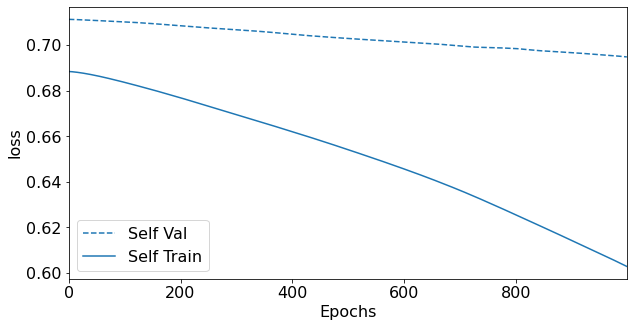

Train acc is 0.581, Val acc is 0.500


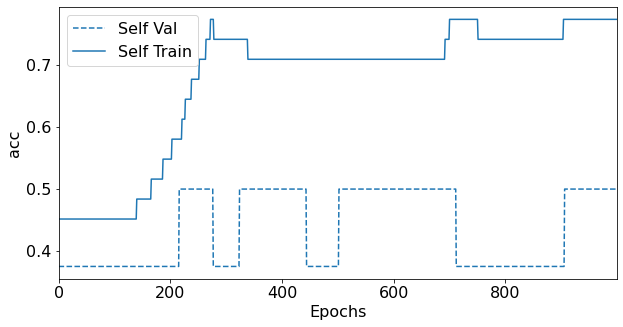

In [156]:
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn import metrics
# from module.util import *
params = {
    'lr': 0.0001,
    'epoch': 1000,
    'batch_size': 128,
    'lambda': 0.01,
    'epsilon': 0.01,
}
label_ref = label_dict['SAVE'].copy()
label_ref[label_ref<=2] = 0
label_ref[label_ref>2] = 1

data = rep_load_dict['SAVE']
params = make_param_int(params, ['batch_size'])
label = to_categorical(label_ref.copy(), dtype=int)
label = label.astype(float)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.9875, random_state = 0, stratify = label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0, stratify = y_train)

""" 
CNN based feature selection
"""
# reshape
# X_train = X_train.reshape(-1,7, 24*2, 1)
# X_test = X_test.reshape(-1,7, 24*2, 1)

# model = CNN_softmax(params, True, label)
model = DNN_model(params, True, label, 48)

es = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

history_self = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_val, y_val),batch_size=params['batch_size'], callbacks = [es])
model_dict['SAVE'] = model

y_pred = model.predict(X_test)
result_test_self = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)).mean()
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_test, axis=1), y_pred[:,0], pos_label=0)
auc_test_self = metrics.auc(fpr, tpr)

y_pred = model.predict(X_val)
result_val_self = (np.argmax(y_pred, axis=1) == np.argmax(y_val, axis=1)).mean()
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_val, axis=1), y_pred[:,0], pos_label=0)
auc_val_self = metrics.auc(fpr, tpr)

print(f'Validation acc is {result_val_self} and Test acc is {result_test_self}')
print(f'Validation auc is {auc_val_self} and Test auc is {auc_test_self}')

plot_history([('self', history_self)],key='loss')
plot_history([('self', history_self)],key='acc')


In [163]:
v, c = np.unique(np.argmax(y_test, axis=1), return_counts=True)
c / c.sum()

array([0.55401483, 0.44598517])

## Functions (나중에 util로 옮길 것)

In [21]:
def CNN_softmax(params, binary, label):

    '''

    Parameters
    ----------
    params: DNN learning parameters
    binary: binary or not
    label: y

    Returns
    -------
    model: compiled DNN model

    '''

    x_input = Input(shape=(7, 24*2, 1))
    # x_input = Input(shape=(2, 24, 1))
    x = Conv2D(8, kernel_size = (2,3), activation='relu', input_shape=(7, 24*2, 1))(x_input)
    x = Conv2D(16, kernel_size =(3,3) , activation='relu')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(32, input_shape=(320,))(x)

    # Add svm layer
    x_out = Dense(label.shape[1], input_shape=(32,),
                  activation='softmax', use_bias=True)(x)

    model = Model(x_input, x_out)
    optimizer = Adam(params['lr'], epsilon=params['epsilon'])
    # model.compile(optimizer=optimizer, loss='squared_hinge')
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model


In [30]:
def DNN_model(params, binary, label, n_feature):

    '''

    Parameters
    ----------
    params: DNN learning parameters
    binary: binary or not
    label: y

    Returns
    -------
    model: compiled DNN model

    '''

    x_input = Input(shape=(n_feature,))
    # x_input = Input(shape=(2, 24, 1))
    x = Dense(64, activation='relu', input_shape=(n_feature,))(x_input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64)(x)

    # Add svm layer
    x_out = Dense(label.shape[1], activation='softmax', use_bias=True)(x)

    model = Model(x_input, x_out)
    optimizer = Adam(params['lr'], epsilon=params['epsilon'])
    # model.compile(optimizer=optimizer, loss='squared_hinge')
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics =['acc'])
    return model


In [32]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(10,5))

    for name, history in histories:
      val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
      plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
      
      if key == 'acc':
        idx = np.argmax(history.history['val_'+key])
      else:
        idx = np.argmin(history.history['val_'+key])
      best_tr = history.history[key][idx]
      best_val = history.history['val_'+key][idx]
      
      print('Train {} is {:.3f}, Val {} is {:.3f}'.format(key, best_tr,key, best_val))

    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    plt.show()